# EcoDynElec - Enr Model - Export for EcoDynElec - 2016 to 2022

This notebook allows you to merge the 2016-2022 predicted data csv (generated in the example notebook for wind and solar energy) with the rest of the Pronovo data from May 2020 to December 2022 (including Biogas, Biomass and renewable Waste productions).
Pronovo and EnergyCharts (EC) data are compared over the whole time period to choose the best data for each renewable power production mean.
The resulting csv file can then be used in EcoDynElec to complete the ENTSO-E data.

### 0. Utility functions

In [23]:
# auto reload modules
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from ecodynelec_enr_model.data_loading import load_all_pronovo_files, save_power_data, root_dir, pronovo_types_map
from os import listdir

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
def plt_compare_data_sources(src_filter, pronovo_data, ec_data, title):
    """
    Plots the pronovo and energy charts data against each other
    """

    cls = [c for c in pronovo_data.columns if src_filter(c)]
    fig = plt.figure(figsize=(16, 5))
    pronovo_data.resample('D').sum()[cls].plot(ax=fig.gca())
    cls2 = [c for c in ec_data.columns if src_filter(c)]
    (ec_data.resample('D').sum()[cls2]*1000000).plot(ax=fig.gca())

    cls = [f'{c} (Pronovo)' for c in cls]
    cls2 = [f'{c} (EC)' for c in cls2]
    plt.legend(np.concatenate([cls, cls2]))
    plt.title(title)
    plt.ylabel('Electricity production (kWh)')
    plt.show(True)

### 1. Load and reorganize the data from Pronovo

Read Pronovo data

In [6]:
years = [2020, 2021, 2022, 2023]
years = [f'prod_{year}' for year in years]
types = list(pronovo_types_map['2'].keys())
types.append('Biomass_all')
verbose = False

pronovo_data = load_all_pronovo_files(years, types=types, verbose=verbose)
final_data = pronovo_data.sort_index()


Read EnergyCharts (EC) data

In [7]:
ec_types_to_types = {
    'Biogaz': 'Biogas',
    'Biomasse': 'Biomass_all',
    'Cultures énergétiques': 'Biomass_1_crops',
    'Déchets forestiers et agricoles': 'Biomass_2_waste',
    'Incinération': 'Waste_1',
    "Biogaz de station d'épuration": 'Sewage_gas',
    "Gaz d'égout": 'Sewage_gas'
}

ec_data = []
for f in listdir('./ec_data/'):
    if f.endswith('.csv'):
        if verbose: print('reading ' + f)
        data = pd.read_csv('./ec_data/' + f, index_col=0)
        data = data.drop(index=data.index[0], columns=[col for col in data.columns if col.startswith('Unnamed')])
        data = data.rename(columns=ec_types_to_types)
        ec_data.append(data)

df_ec_data = pd.concat(ec_data, axis=0).fillna(0).astype(float)
# create DatetimeIndex from D.M.Y format
df_ec_data.index = pd.to_datetime(df_ec_data.index, format='%d.%m.%Y')

#### Plot and compare them

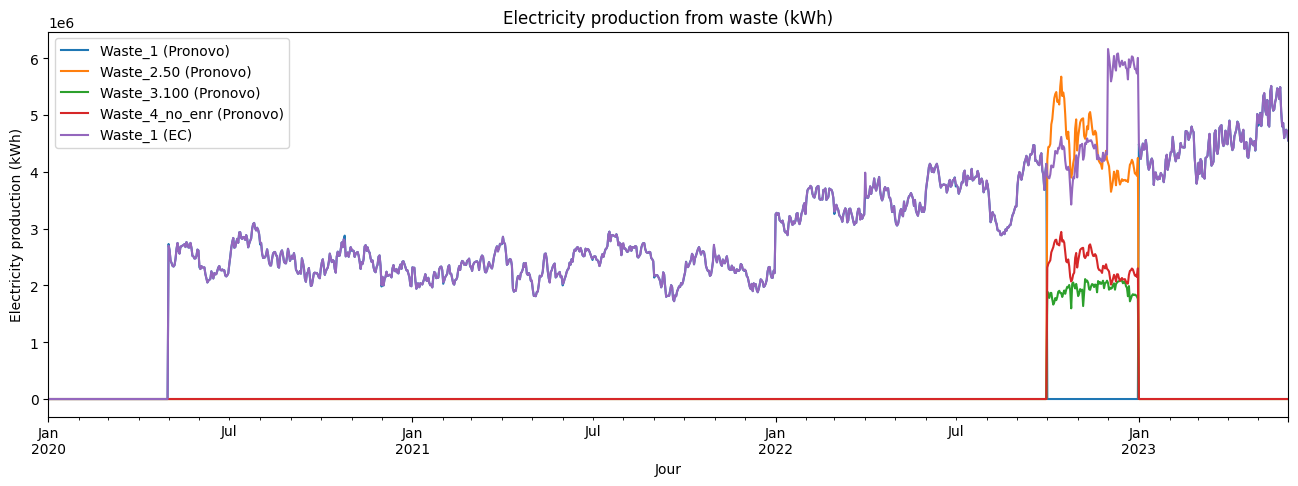

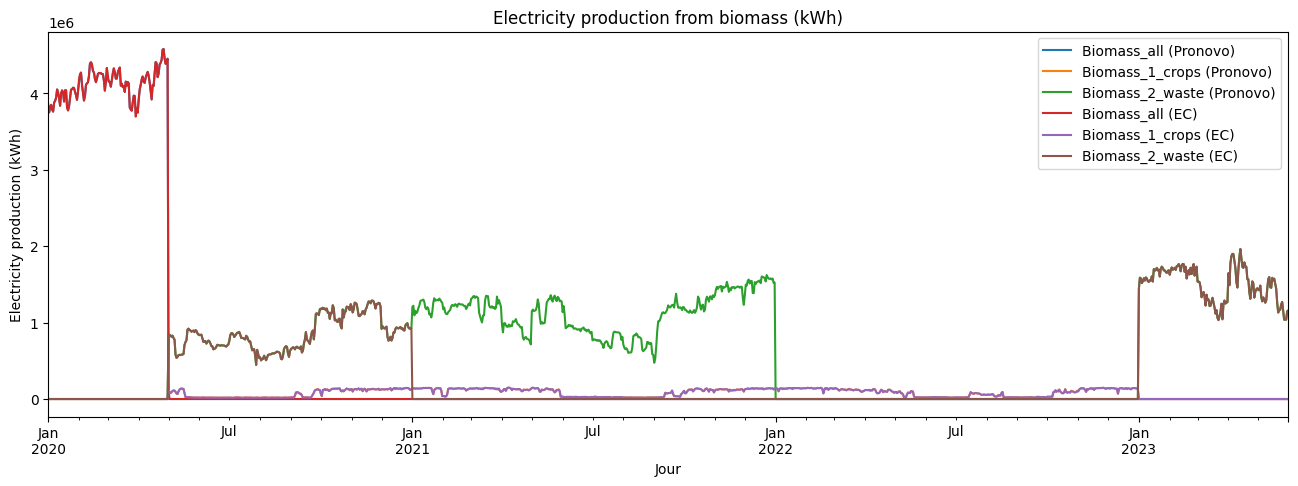

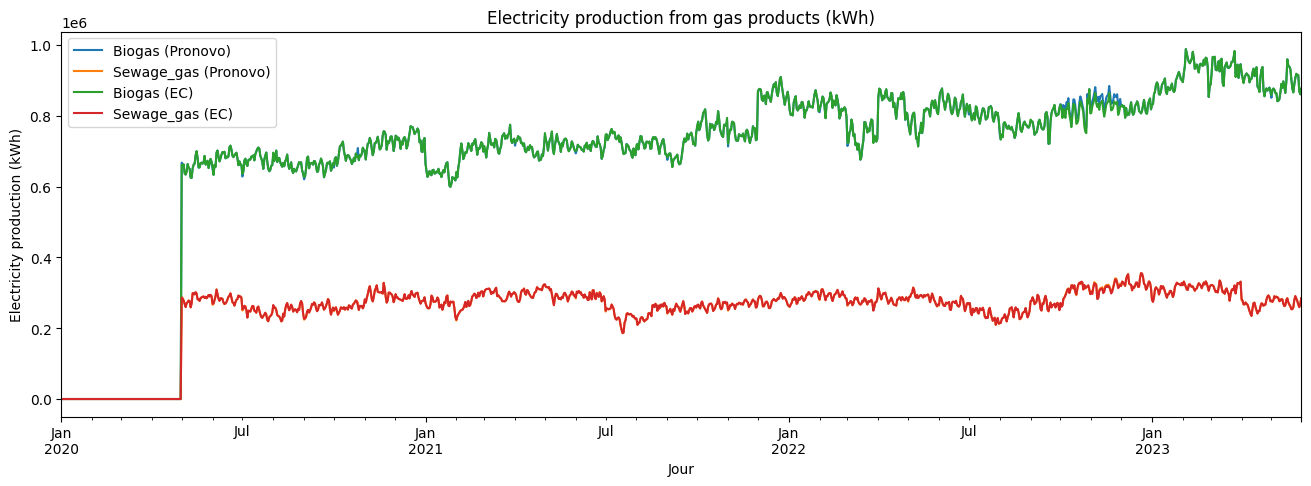

In [9]:
plt_compare_data_sources(lambda c: 'Waste' in c, final_data, df_ec_data, 'Electricity production from waste (kWh)')
plt_compare_data_sources(lambda c: 'Biomass' in c, final_data, df_ec_data, 'Electricity production from biomass (kWh)')
plt_compare_data_sources(lambda c: 'gas' in c, final_data, df_ec_data, 'Electricity production from gas products (kWh)')

#### Reorganization rules

Here we select the best data source for each electricity production mean, for each time period.

Should follow the structure :
```
'Category1': [
    {
        'start': 'start date', # start date in the result (and in source data if from_start isn't set)
        'end': 'end date', # end date in the result (and in source data if from_end isn't set)
        'from_start': '2021-01-01', # optional, start date in the source data (allows to copy data from one date to another)
        'from_end': '2021-12-31', # optional, end data in the source data
        'source': 'Pronovo' or 'EC', # source of the data
        'series': 'Series_Name_In_Source_Data' # name of the column to take in the source data
    },
    ...
],
...
```

In [10]:
data_mappings = {
    'Waste': [
        {
            'start': '2020-05-01',
            'end': '2022-09-30',
            'source': 'Pronovo',
            'series': 'Waste_1'
        },
        {
            'start': '2020-10-01',
            'end': '2022-11-30',
            'source': 'EC',
            'series': 'Waste_1'
        },
        {
            'start': '2022-12-01',
            'end': '2022-12-31',
            'source': 'Pronovo',
            'series': 'Waste_2.50'
        },
        {
            'start': '2023-01-01',
            'end': 'last',
            'source': 'Pronovo',
            'series': 'Waste_1'
        }
    ],
    'Biogas': [
        {
            'start': '2020-05-01',
            'end': 'last',
            'source': 'Pronovo',
            'series': 'Biogas'
        }
    ],
    'Sewage_gas': [
        {
            'start': '2020-05-01',
            'end': 'last',
            'source': 'Pronovo',
            'series': 'Sewage_gas'
        }
    ],
    'Biomass_1_crops': [
        {
            'start': '2020-05-01',
            'end': '2022-12-31',
            'source': 'Pronovo',
            'series': 'Biomass_1_crops'
        }
    ],
    'Biomass_2_waste': [
        {
            'start': '2020-05-01',
            'end': '2021-12-31',
            'source': 'Pronovo',
            'series': 'Biomass_2_waste'
        },
        {
            'start': '2022-01-01',
            'end': '2022-12-31',
            'from_start': '2021-01-01',
            'from_end': '2021-12-31',
            'source': 'Pronovo',
            'series': 'Biomass_2_waste'
        },
        {
            'start': '2023-01-01',
            'end': 'last',
            'source': 'Pronovo',
            'series': 'Biomass_2_waste'
        }
    ]
}

Then we apply these reorganization rules :

In [13]:
mapped_data = pd.DataFrame(index=final_data.index, columns=data_mappings.keys())

for col in data_mappings.keys():
    maps = data_mappings[col]
    for m in maps:
        src_df = df_ec_data.copy() if m['source'] == 'EC' else final_data
        # take the lowest date between end and actual end of source data
        if m['source'] == 'EC':
            src_df = src_df * 1000000 # Convert to kWh
            src_df = src_df.resample('H').ffill() / 24 # Convert to hourly data (with a uniform repartition over the day in first approximation)
        if m['end'] == 'last':
            m['end'] = '2023-03-31' # Use the real end of the data
        if 'from_start' in m:
            # copy from one date to another date
            start = datetime.strptime(m['start'], '%Y-%m-%d')
            end = datetime.strptime(m['end'], '%Y-%m-%d')
            from_start = datetime.strptime(m['from_start'], '%Y-%m-%d')
            from_end = datetime.strptime(m['from_end'], '%Y-%m-%d')
            pouf = src_df.loc[from_start:from_end, m['series']].copy()
            pouf.index = mapped_data.loc[start:end, col].index
            mapped_data.loc[start:end, col] = pouf
        else:
            # simple copy
            start = datetime.strptime(m['start'], '%Y-%m-%d')
            end = datetime.strptime(m['end'], '%Y-%m-%d')
            mapped_data.loc[start:end, col] = src_df.loc[start:end, m['series']]

Plot the reorganized production data

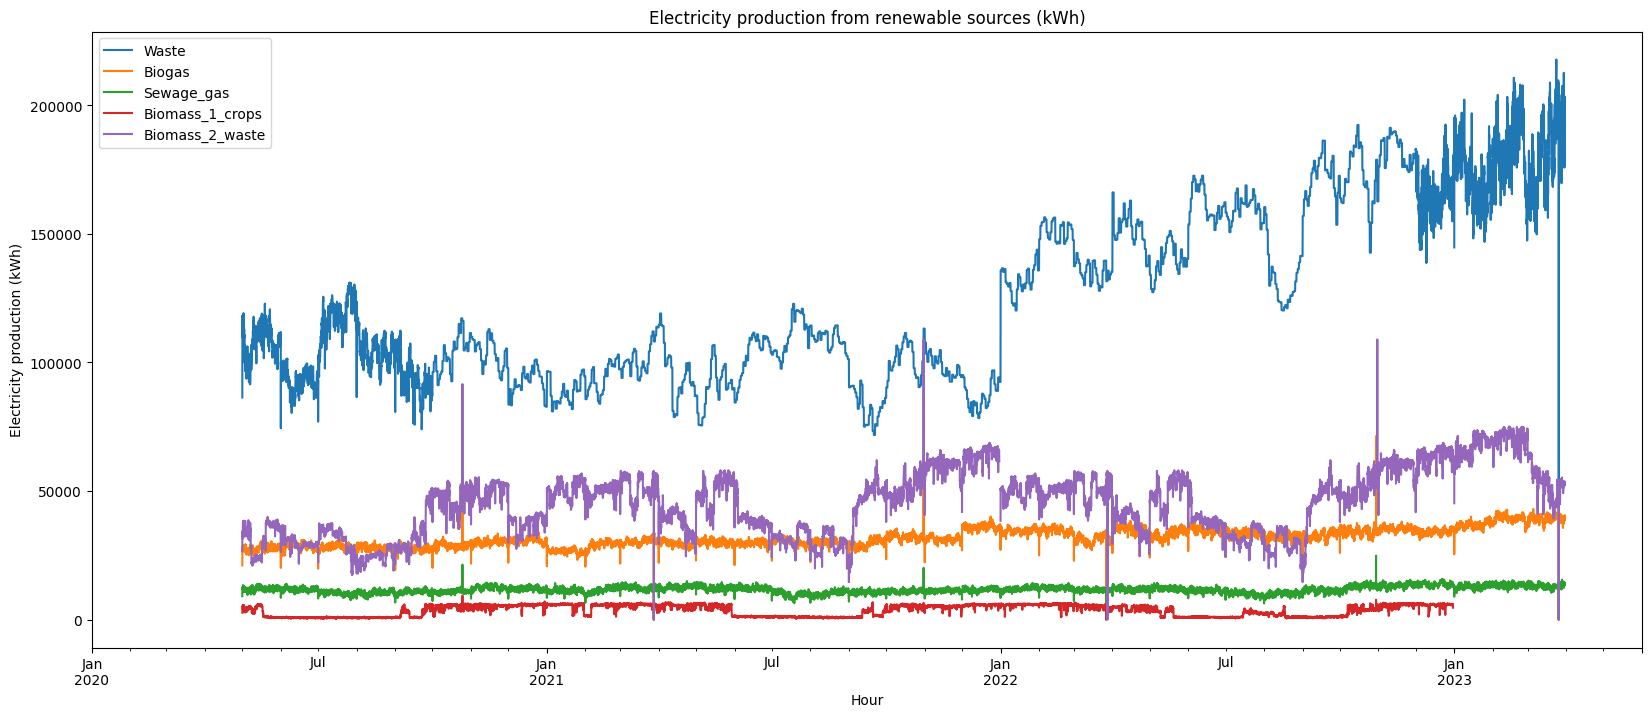

In [14]:
mapped_data.plot(figsize=(20, 8))
plt.title('Electricity production from renewable sources (kWh)')
plt.xlabel('Hour')
plt.ylabel('Electricity production (kWh)');

And save it

In [15]:
mapped_data = mapped_data.loc['2020-05-01':'2023-03-31 00:00:00']
mapped_data.to_csv('recomposed_biomass.csv')

### 2. Load the wind and solar data from Ecd-Enr-Model (example notebook)

In [16]:
solarwind = pd.read_csv('ecd_enr_model/export/enr_prod_2016-2022.csv', index_col=0, parse_dates=[0])

### 3. Merge it

In [17]:
#mapped_data = pd.read_csv('recomposed_biomass.csv', index_col=0, parse_dates=[0])

In [20]:
ndf = pd.concat([solarwind, mapped_data], axis=1)
ndf.fillna(0, inplace=True)

Plot it

<Axes: >

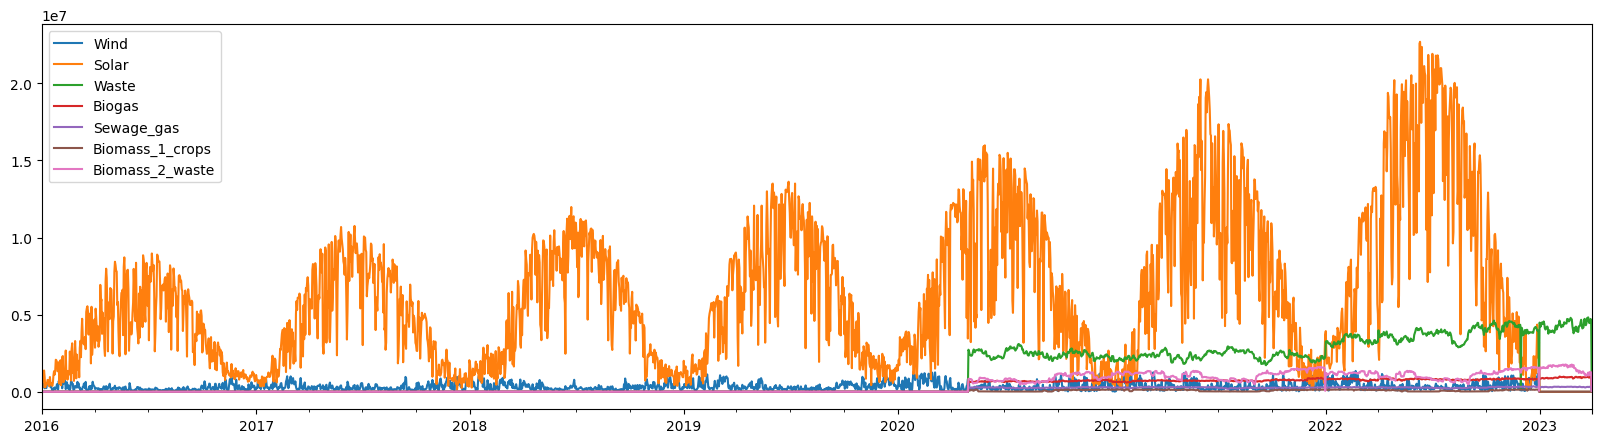

In [21]:
ndf.resample('D').sum().plot(figsize=(20, 5))

And save it

In [22]:
ndf.to_csv('ecd_enr_model/export/enr_prod_2016-2022_completed.csv')